In [1]:
import importlib
from itertools import combinations
from urllib.request import urlopen

import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pylab as plt
from jax import vmap
from matplotlib.colors import hsv_to_rgb
from sbmltoodejax.modulegeneration import GenerateModel
from sbmltoodejax.parse import ParseSBMLFile

# Utils 

In [2]:
def generate_model(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):

    model_jax_file = "jax_model.py"
    model_url = f"https://www.ebi.ac.uk/biomodels/model/download/BIOMD{model_idx:010d}.2?filename=BIOMD{model_idx:010d}_url.xml"
    with urlopen(model_url) as response:
        model_xml_body = response.read().decode("utf-8")
    model_data = ParseSBMLFile(model_xml_body)
    GenerateModel(
        model_data,
        model_jax_file,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    return model_jax_file


def load_model(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):
    model_jax_filepath = generate_model(
        model_idx,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    spec = importlib.util.spec_from_file_location("JaxModelSpec", model_jax_filepath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    model_cls = getattr(module, "ModelRollout")
    model = model_cls()
    y0 = getattr(module, "y0")
    w0 = getattr(module, "w0")

    return model, y0, w0

{'C': 0, 'M': 1, 'X': 2, 'Y': 3, 'Z': 4}


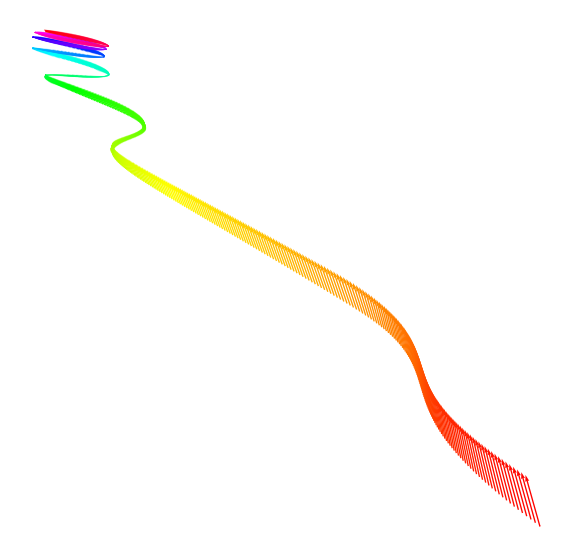

In [4]:
n_secs=100
model_idx=8
y1 = "Z"  # X
y2 = "Y"  
model, y0, w0 = load_model(model_idx)
ys, ws, times = model(int(n_secs / model.deltaT))
print(model.modelstepfunc.y_indexes)
y1_idx = model.modelstepfunc.y_indexes[y1]
y2_idx = model.modelstepfunc.y_indexes[y2]

plot_every = 1
X = ys[y1_idx, :-1][::plot_every]
Y = ys[y2_idx, :-1][::plot_every]
U = ys[y1_idx, 1:][::plot_every] - ys[y1_idx, :-1][::plot_every]
V = ys[y2_idx, 1:][::plot_every] - ys[y2_idx, :-1][::plot_every]
c = [hsv_to_rgb((step / len(X), 1, 1)) for step in range(len(X))]

fig = plt.figure(figsize=(10, 10))
plt.quiver(X, Y, U, V, color=c)
plt.axis("off")
plt.show()
fig.savefig("logo.png", format="png", dpi=1200)
fig.savefig("logo.svg", format="svg", dpi=1200)